## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX1_Stutter.ipynb?download&target=_blank).

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Application: N-Link Inverse Dynamics](../id_lmx4_nlink)

In [1]:
import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

import WrenchToolbox as WT # contains an improved "Wrench" object

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)


# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )

The custom Wrench Toolbox [can be downloaded here.](WrenchToolbox.py?download&target=_blank)

# Elementary Example 1: A Stuttering Motor

The Euler force emerges when a rotation is not constant in its velocity, but changes due to non-zero angular acceleration. 
If you think about where that happens, you will find that the Euler force is omnipresent, and it can have severe implications.

For example, in our [3D²YMOX](https://www.uantwerpen.be/en/research-groups/3d2ymox?target=_blank) setup at UA, we had colleagues attempting to scan rotating calibration objects. 
So they constructed a rotating table on which to mount the objects. 
It turned out that a prototype of the motor did not rotate at a steady angular velocity, but instead "wobbled" (oscillating angular velocity). 
Besides producing artifacts in the scans (the major concern in that case), there was certainly also an Euler force at play. 


This example notebook is written in honor of the brave colleagues who solved that rotation table problem. 

Here is a sketch of the idealized situation:

<img src="images/id_lmx_1.svg" width="500px"> </img>


Two point masses rotate symmetrically around a central joint. 
However, angular velocity is not constant, but changes in a periodic manner. 
All other settings are as before. 

# Initialization

This time, the angular velocity has a time-dependent component, so angular acceleration will be non-zero.

In [2]:
# time, length, mass, gravitational acceleration
t, l, m = SYM.symbols('t, l, m', real = True)

# set the period of rotation
period = SYM.symbols('T', real = True)

# this defines the angular velocity by 2π/T, with an additional, time-dependent component
φdot = 2.*SYM.pi/period + 0.1 * SYM.sin(2*t)

# the angle φ is a function of time
φ = SYM.Function('φ')(t)

# the angular velocity is equal to the first derivative of the angle
φ_function = SYM.integrate(φdot, t)

# we will store this for substitution later, 
# for being able to calculate with angles, and then break it down to time.
φ_substitutes = {φ: φ_function}

φ_substitutes

{φ: -0.05*cos(2*t) + 2.0*pi*t/T}

Some of the values are constant, and we would like to substitute those in sometimes to numerically inspect our example.

In [3]:
constants = {  l: 1. # m \
             , m: 1. # kg \
             , period: 2.*SYM.pi # s \
             , SYM.pi: NP.pi # = 3.0 \
            }

# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(φ_substitutes).doit().subs(constants).subs(constants) \
                                )))

# Reference Frames

The situation is as before with $\{S\}$ = static frame = inertial frame and a body frame $\{B\}$. 


In [4]:
world = MECH.ReferenceFrame('S')

# initialize the {B} frame as rotated relative to the world by φ around the world's z axis.
body = world.orientnew('B', 'Axis', (φ, world.z))

# we give the body frame angular velocity and acceleration
body.set_ang_vel(world, φdot*world.z)
body.set_ang_acc(world, φdot.diff(t)*world.z) # should be zero in our case

body.ang_acc_in(world).to_matrix(world).T

Matrix([[0, 0, 0.2*cos(2*t)]])

Note how this time, the body frame accelerates.

Because it can get complex with multiple reference frames, here is a dictionary which is able to transform *to* all frames (first index), *from* any other frame (second index).

In [5]:
# prepare a list of (label/frame) tuples.
frames = [('S', world), ('B', body)]

# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {label: {} for label, _ in frames}
for label_from, frame_from in frames:
    for label_to, frame_to in frames:
        trafo[label_to][label_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example
PlugAllIn(trafo['S']['B'])

Matrix([
[cos(t - cos(2*t)/20), -sin(t - cos(2*t)/20), 0],
[sin(t - cos(2*t)/20),  cos(t - cos(2*t)/20), 0],
[                   0,                     0, 1]])

Even though the matrix elements are more complex than before, keep trying to mentally plug in specific time points ($t=0$, $t=\frac{\pi}{2}$, ...) to confirm that this matrix makes sense, and even more important to see that all signs and directions are plausible. Also, you could modify the code above and reduce the amplitude of the angular acceleration to zero, to see if the transformation matches a previous result.

# Points

Our toy system has several points of interest: 
- the world origin
- two point masses ($P_{-1},\ P_{+1}$)
- a joint, which is also the center of mass (COM) of the two point masses

What makes a joint a joint? We define it as one.

In [6]:
# define the origin
origin = MECH.Point('O')

# the origin does not move
origin.set_vel(world, 0)
origin.set_acc(world, 0)



### define COM of the rigid body
com = MECH.Point('A')

## set position of COM
com.set_pos(origin, sum([0*n for n in GetCoordinates(world)]))

## set position vector time derivatives
# (i) in the body frame
com.set_vel(body, 0)
com.set_acc(body, 0)

# (ii) in the static frame
com.set_vel(world, com.pos_from(origin).diff(t, world).simplify())
com.set_acc(world, com.vel(world).diff(t, world).simplify())



## two points at opposite positions
positions = [+1,-1]
points = {pos: MECH.Point('C_{%i}' % (pos)) for pos in positions}

# iteratively initialize points
for pos, point in points.items():
    # position: at distance l from the origin
    point.set_pos(com, pos * l * body.y)
    
    # points do not move relative to the body frame
    point.set_vel(body, point.pos_from(com).diff(t, body).simplify())
    point.set_acc(body, point.vel(body).diff(t, body).simplify())

    # set velocity of point in static rf
    point.set_vel(world, point.pos_from(origin).diff(t, world).simplify())
    point.set_acc(world, point.vel(world).diff(t, world).simplify())

    
    
# print an example point acceleration
SYM.pprint(PlugAllIn(points[-1].acc(world).express(world).to_matrix(world)).T)

⎡                 2    ⎛    cos(2⋅t)⎞               ⎛    cos(2⋅t)⎞            
⎢  (sin(2⋅t) + 10) ⋅sin⎜t - ────────⎟   cos(2⋅t)⋅cos⎜t - ────────⎟  (sin(2⋅t) 
⎢                      ⎝       20   ⎠               ⎝       20   ⎠            
⎢- ────────────────────────────────── + ──────────────────────────  ──────────
⎣                 100                               5                         

     2    ⎛    cos(2⋅t)⎞      ⎛    cos(2⋅t)⎞            ⎤
+ 10) ⋅cos⎜t - ────────⎟   sin⎜t - ────────⎟⋅cos(2⋅t)   ⎥
          ⎝       20   ⎠      ⎝       20   ⎠            ⎥
──────────────────────── + ──────────────────────────  0⎥
     100                               5                ⎦


I am really glad that the computer calculated that one for me.

# Inertial Properties

I'll treat the two symmetrical points as a compound rigid body, instead of storing separate $I$. 
Hence, their Steiner components add up. 
Interestingly, the Steiner theorem for point masses resembles the general formula of mass moment of inertia, which also constructs a total $I$ from mass elements.

In [7]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(body, 0, 0, 0)

I_B = {}
# the system has an inertia relative to the origin, which coincides with the center of mass.
for pt, refpoint in [('P', points[-1]), ('C', com), ('O', origin)]:
    I_B[pt] = inertia.to_matrix(body)\
                + GeneralizedSteiner(  m, points[-1].pos_from(refpoint).express(body).to_matrix(body) )
    
for pt, refpoint in [('P', points[+1]), ('C', com), ('O', origin)]:
    I_B[pt] = I_B[pt] + GeneralizedSteiner(  m, points[+1].pos_from(refpoint).express(body).to_matrix(body) )


# all the I's can be transformed to the inertial reference frame
I_S = {}
for refpoint in I_B.keys():
    I_S[refpoint] = SYM.simplify(trafo['S']['B'] * I_B[refpoint] )

# print an example
PlugAllIn(I_S['C'])



Matrix([
[2*cos(t - cos(2*t)/20), 0, 0],
[2*sin(t - cos(2*t)/20), 0, 0],
[                     0, 0, 2]])

# Kinematics

Kinematics are the description of how the points move.
There are the different reference frames, and the different derivatives of position vectors, and all of those should be available when desired. 

To keep good overview, I use nested dictionaries again.

In [8]:
# shorthands for the derivative levels
p = 0 # zero'th derivative: the position vector
v = 1 # first derivative: the velocity
a = 2 # second derivative: the acceleration

In [9]:
x = {}

# position vectors in different reference frames
x['S'] = {pos: [point.pos_from(origin).express(world).to_matrix(world)] for pos, point in points.items()}
x['B'] = {pos: [point.pos_from(origin).express(body).to_matrix(body)] for pos, point in points.items()}

# ... and their differentials
for frame in x.keys():
    for diff_nr in range(2): 
        for pos in x[frame].keys(): 
            x[frame][pos].append(SYM.simplify(x[frame][pos][-1].diff(t)))

# example
PlugAllIn(x['S'][+1][a]).T

Matrix([[(sin(2*t) + 10)**2*sin(t - cos(2*t)/20)/100 - cos(2*t)*cos(t - cos(2*t)/20)/5, -(sin(2*t) + 10)**2*cos(t - cos(2*t)/20)/100 - sin(t - cos(2*t)/20)*cos(2*t)/5, 0]])

Almost analogously, we "measure" (i.e. store) the angular kinematics.

In [10]:
ω = {}

# time-varying angle
ω['S'] = [SYM.Matrix([[0],[0],[φ]])]
ω['B'] = [SYM.Matrix([[0],[0],[0]])]

# ... and its time derivatives.
for frame in ω.keys():
    for diff_nr in range(2): 
        ω[frame].append(SYM.simplify(ω[frame][-1].diff(t)))

# example
SYM.pprint(PlugAllIn(ω['S'][a] - body.ang_acc_in(world).to_matrix(world) ).T) # <- good check
PlugAllIn(ω['S'][a]).T

[0  0  0]


Matrix([[0, 0, cos(2*t)/5]])

# Visualization

As always, it might be useful to plot the trajectories, to see whether they match your expectation.

In [11]:
time = NP.linspace(0., 2*NP.pi, 60, endpoint = False)
position = SYM.lambdify(t, PlugAllIn(x['S'][+1][p]), 'numpy')
lin_velocity = SYM.lambdify(t, PlugAllIn(x['S'][+1][v]), 'numpy')
lin_acceleration = SYM.lambdify(t, PlugAllIn(x['S'][+1][a]), 'numpy')
ang_velocity = SYM.lambdify(t, PlugAllIn(ω['S'][v]), 'numpy')
ang_acceleration = SYM.lambdify(t, PlugAllIn(ω['S'][a]), 'numpy')
# position(time)

Here I color by angular velocity.

In [12]:
y = [pos[0] for pos in position(time)] 
# print(y)

v_values = ang_velocity(time)

# arrange in arrays of equal lengths
for v_nr, val in enumerate(v_values):
    if (len(val) == 1) and NP.all(NP.sum(NP.abs(val)) == 0):
        v_values[v_nr] = [NP.zeros((len(time),))]
        
# stack velocities
vel = NP.stack([val[0] for val in v_values], axis = 1)

# get a color from v magnitude
v_mag = NP.sqrt(NP.sum(NP.power(vel, 2), axis = 1))
v_cval = v_mag - NP.min(v_mag)

# MPP.plot(time, v_cval);
# MPP.show()

<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[-sin(t - 1/20*cos(2*t))], [cos(t - 1/20*cos(2*t))], [0]]))
<lambdifygenerated-4>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[0], [0], [(1/10)*sin(2*t) + 1]]))


And here is a simple 2D plot:

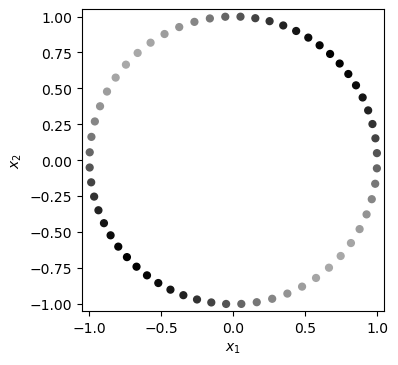

In [13]:

fig = MPP.figure(dpi = 100)
ax = fig.add_subplot(1,1,1,aspect = 'equal')
ax.scatter(y[0], y[1], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_ylim(NP.array([-1.05,1.05])*(constants[l]))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
MPP.show();

# Fictitious Forces

Before we move to kinetics, I find it a good strategy to recall what we expect. 
Refer to the [documents by Frank Owen](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank) if in doubt.

Here is what we would expect for the **Euler Force:**

$F_e = -m\ddot{\tilde{\omega}}_{B} \times {x}_{B}$


We can even store separate forces for both point masses, to see whether they cancel.

In [14]:
F_e_B = {pos: -(trafo['B']['S']*ω['S'][a]).cross(x['B'][pos][p]) \
           for pos, point in points.items() }

PlugAllIn(F_e_B[-1]).T, PlugAllIn(F_e_B[+1]).T

(Matrix([[-cos(2*t)/5, 0, 0]]), Matrix([[cos(2*t)/5, 0, 0]]))

Here is what we would expect for the **Centrifugal Force:**

$F_{cf} = -m\dot{\tilde{\omega}}_{B} \times \left(\dot{\tilde{\omega}}_{B} \times {x}_{B} \right)$



In [15]:
F_cf_B = {pos: -m*((trafo['B']['S']*ω['S'][v]).cross((trafo['B']['S']*ω['S'][v]).cross(x['B'][pos][p]))) \
          for pos, point in points.items()}
[PlugAllIn(F).T for F in F_cf_B.values()]

[Matrix([[0, (sin(2*t) + 10)**2/100, 0]]), Matrix([[0, -(sin(2*t) + 10)**2/100, 0]])]

Thirdly, the **Coriolis Force:**

$F_{cor} = -2m\dot{\tilde{\omega}}_{B} \times \dot{{x}}_{B}$



In [16]:
F_cor_B = {pos: -2*m*((trafo['B']['S']*ω['S'][v]).cross(x['B'][pos][v])) \
          for pos, point in points.items()}
[PlugAllIn(F).T for F in F_cor_B.values()]

[Matrix([[0, 0, 0]]), Matrix([[0, 0, 0]])]

Apparently, none of the fictitious forces is of our concern, they are all symmetric in this example.

Or do they concern us?
We'll see.

# Kinetics / Inverse Dynamics

Recall that **the time change of momentum/angular momentum of a rigid body is equal to the sum of external forces/moments acting on it.** This is the conservation of momentum. 

$ \sum F = m\ddot{x} + \frac{\partial m}{\partial x} \dot{x}\dot{x}  $


$ \sum M = I\ddot{\omega} + \dot{\omega} \times I\dot{\omega}$



## Balance of Wrenches

In the inertial frame, everything works as outlined before:

(1) define the unknown joint wrench.

In [17]:
force_components_S = SYM.symbols('f_{JS1:4}', real = True)
moment_components_S = SYM.symbols('m_{JS1:4}', real = True)

joint_wrench_S = WT.Wrench.FromComponents(world, com, force_components_S, moment_components_S)

SYM.pprint(joint_wrench_S.Matrix().T)


[f_{JS1}  f_{JS2}  f_{JS3}  m_{JS1}  m_{JS2}  m_{JS3}]


(2) assemble LHS dynamic wrench.

In [18]:
# we'll need to sum up the points individually
dynamic_force_S = m*x['S'][-1][a] + m*x['S'][+1][a]
SYM.pprint(PlugAllIn(dynamic_force_S).T)

# I's are already a sum of two points' inertias
dynamic_moment_S = I_S['C']*ω['S'][a] + ω['S'][v].cross(I_S['C']*ω['S'][v]) 
SYM.pprint(PlugAllIn(dynamic_moment_S).T)

# assembling the dynamic wrench
dynamic_wrench_S = WT.Wrench.FromMatrices(world, com, dynamic_force_S, dynamic_moment_S \
                       )


PlugAllIn(dynamic_wrench_S.Matrix()).T

[0  0  0]
⎡      2⋅cos(2⋅t)⎤
⎢0  0  ──────────⎥
⎣          5     ⎦


Matrix([[0, 0, 0, 0, 0, 2*cos(2*t)/5]])

(3) generate and solve the equations:

In [19]:
# get the equations (one per component)
equations_S = dynamic_wrench_S.Equate(joint_wrench_S)

# desired outcome variables
components_S =  [*force_components_S, *moment_components_S]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_S \
                           , components_S \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JS = WT.Wrench.FromMatrix(world, com, SYM.Matrix([[solutions[cmp]] for cmp in components_S]) )
SYM.pprint(PlugAllIn(W_JS.Matrix()).T)

⎡               2⋅cos(2⋅t)⎤
⎢0  0  0  0  0  ──────────⎥
⎣                   5     ⎦


This is our reference result. 
And it is plausible: the Euler force, although the force cancels, produces a net torque around the $\hat{x}_3$ axis (twice the magnitude because there are two point masses).

## Body Frame

The results in the body frame must match.

In [20]:
euler_wrench = WT.Wrench(body, com)

for pos, point in points.items():
    euler_wrench = euler_wrench \
                       + WT.Wrench(body, point \
                            , MatrixToVector(-m*((trafo['B']['S']*ω['S'][a]).cross(x['B'][pos][p])), body) \
                             )

SYM.pprint(PlugAllIn(euler_wrench.Matrix()).T)

⎡               -2⋅cos(2⋅t) ⎤
⎢0  0  0  0  0  ────────────⎥
⎣                    5      ⎦


This is the confirmation: total Euler force is zero (due to symmetry), but it produces a moment (torque) at the center. 
Makes sense, because in order to have a changing angular velocity, a moment is required. 

The other fictitious wrenches are zero:

In [21]:
centrifugal_wrench = WT.Wrench(body, com)

for pos, point in points.items():
    centrifugal_force = -m*((trafo['B']['S']*ω['S'][v]).cross((trafo['B']['S']*ω['S'][v]).cross(x['B'][pos][p])))
    centrifugal_wrench = centrifugal_wrench \
                       + WT.Wrench(body, point \
                            , MatrixToVector(centrifugal_force, body) \
                             )

SYM.pprint(PlugAllIn(centrifugal_wrench.Matrix()).T)

[0  0  0  0  0  0]


In [22]:
coriolis_wrench = WT.Wrench(body, com)

for pos, point in points.items():
    coriolis_wrench = coriolis_wrench \
                       + WT.Wrench(body, point \
                            , MatrixToVector(-2*m*(trafo['B']['S']*ω['S'][v].cross(x['B'][pos][v])), body) \
                             )

SYM.pprint(PlugAllIn(coriolis_wrench.Matrix()).T)

[0  0  0  0  0  0]


Then we need a placeholder for the unknown joint wrench.

In [23]:
force_components_B = SYM.symbols('f_{JB1:4}', real = True)
moment_components_B = SYM.symbols('m_{JB1:4}', real = True)

joint_wrench_B = WT.Wrench.FromComponents(body, com, force_components_B, moment_components_B)

SYM.pprint(joint_wrench_B.Matrix().T)

[f_{JB1}  f_{JB2}  f_{JB3}  m_{JB1}  m_{JB2}  m_{JB3}]


And finally, the left hand side dynamic wrench.

In [24]:
dynamic_force_B = m*x['B'][-1][a] \
                + m*x['B'][+1][a]

dynamic_moment_B = I_B['C']*ω['B'][a] + ω['B'][v].cross(I_B['C']*ω['B'][v])

# assembling the dynamic wrench
dynamic_wrench_B = WT.Wrench.FromMatrices(body, com, dynamic_force_B, dynamic_moment_B \
                       )


PlugAllIn(dynamic_wrench_B.Matrix()).T

Matrix([[0, 0, 0, 0, 0, 0]])

And here we add all of them up.

In [25]:
equations = dynamic_wrench_B.Equate(joint_wrench_B + euler_wrench + centrifugal_wrench + coriolis_wrench)

components_B =  [*force_components_B, *moment_components_B]

solutions = {}
for param, sol in SYM.solve(equations \
                           , components_B \
                           ).items():
    solutions[param] = sol

W_JB = WT.Wrench.FromMatrix(body, com, SYM.Matrix([[solutions[cmp]] for cmp in components_B]) )
SYM.pprint(PlugAllIn(W_JB.Matrix()).T)

⎡               2⋅cos(2⋅t)⎤
⎢0  0  0  0  0  ──────────⎥
⎣                   5     ⎦


Voilà: this matches our previous result.

In [26]:
SYM.pprint(PlugAllIn(W_JS.express(body).Matrix()).T)

⎡               2⋅cos(2⋅t)⎤
⎢0  0  0  0  0  ──────────⎥
⎣                   5     ⎦


# Summary

This elementary example has proven to be a convenient situation for the study of the moment due to Euler force.
Most of the above was a repitition. 
However, I wanted to point out several things:
- We can combine point masses and choose joints as we like. The calculation will always follow the same procedure.
- In particular, calculation of Mass Moment of Inertia $I$ can get complex, but the computer can handle.
- Although the fictitious forces disappear due to symmetry, there is an Euler moment.


I hope the general procedure is starting to sink in. 
The next example will be about **Centrifugal force and its dual character with the Centripetal force**, but be aware: [the demonstration involves scratching vinyl records with a needle](../id_lmx2_vinyl).

# References

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.